## Import Libraries

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import localtime
import skimage.io as skio
from IPython.display import clear_output
from time import localtime
from tqdm.notebook import tqdm
import cv2

## Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Dataset

In [8]:
os.environ['KAGGLE_USERNAME'] = 'alinourian'
os.environ['KAGGLE_KEY'] = 'd2a7bdbe1fd58ee9456c3def91ed9758'

main_dir = 'Dataset'
!kaggle datasets download -d kmader/siim-medical-images
path_zip = 'siim-medical-images.zip'

!unzip "$path_zip" -d "$main_dir/"
clear_output()

In [11]:
class CTDataset(Dataset):
    def __init__(self, dir, input_size=(512, 512), mode='train', patch_size=None, stride=None):
        self.main_dir = dir
        self.image_width, self.image_height = input_size

        df = pd.read_csv(self.main_dir + '/overview.csv')
        if mode == 'train':
            self.files_name = df.tiff_name.values[:80]
        else:
            self.files_name = df.tiff_name.values[80:]
        
        if patch_size is None:
            self.patch_size = (self.image_width, self.image_height)
            self.stride = 1
            self.n_patches = 1
        else:
            self.patch_size = patch_size
            self.stride = stride
            self.n_width_patches = (self.image_width - patch_size[0]) // stride + 1
            self.n_height_patches = (self.image_height - patch_size[1]) // stride + 1
            self.n_patches = self.n_width_patches * self.n_height_patches
    
    def __len__(self):
        return len(self.files_name) * self.n_patches
    
    def __getitem__(self, index):
        im = self.get_row_item(index)

        noise = np.random.normal(0, .1, im.shape)
        noisy_im = im + noise
        noisy_im[noisy_im < 0] = 0
        noisy_im[noisy_im > 1] = 1

        return torch.tensor(noisy_im, dtype=torch.float32), torch.tensor(im, dtype=torch.float32)
    
    def get_row_item(self, index):
        file_index = index // self.n_patches
        patch_index = index - file_index * self.n_patches
        im = skio.imread(self.main_dir + '/tiff_images' + '/' + self.files_name[file_index])
        im = im.reshape((1, self.image_width, self.image_height))
        im = (np.array(im) - np.min(im)) / (np.max(im) - np.min(im))

        start_patch_i = patch_index // self.n_width_patches
        start_patch_j = patch_index - start_patch_i * self.n_width_patches
        start_index_i, start_index_j = start_patch_i * self.stride, start_patch_j * self.stride
        im = im[:, start_index_i:start_index_i + self.patch_size[0], start_index_j:start_index_j + self.patch_size[1]]
        return im

In [23]:
image_size = (512, 512)
patch_size = (512, 512)
stride = 1
batch_size = 5

train_ds = CTDataset(dir=main_dir, input_size=image_size, mode='train', patch_size=patch_size, stride=stride)
test_ds = CTDataset(dir=main_dir, input_size=image_size, mode='test', patch_size=patch_size, stride=stride)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [24]:
print(f'length of train_ds: {train_ds.__len__()}, length of test_ds: {test_ds.__len__()}')

X, Y = train_ds.__getitem__(2)
print(f'Input size: {X.shape}, Output size: {Y.shape}')

print('Estimate of loading time:')
for i in tqdm(range(train_ds.__len__())):
    data, label = train_ds.__getitem__(i)

length of train_ds: 80, length of test_ds: 20
Input size: torch.Size([1, 512, 512]), Output size: torch.Size([1, 512, 512])
Estimate of loading time:


  0%|          | 0/80 [00:00<?, ?it/s]

## Training Functions

In [15]:
def train_epoch(net, criterion, optimizer, dataloader):
  epoch_loss = 0
  train_loss = 0
  i = 0

  net.train()
  for i, (x, y) in tqdm(enumerate(dataloader)):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    loss = criterion(p, y)
    epoch_loss += float(loss)
    
    train_loss = epoch_loss / (i + 1)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  return train_loss


def evaluate_epoch(net, criterion, dataloader):
  epoch_loss = 0
  eval_loss = 0
  i = 0

  net.eval()
  for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    loss = criterion(p, y)
    epoch_loss += float(loss)

    eval_loss = epoch_loss / (i + 1)

  return eval_loss


def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)


def train_model(net, n_epochs, criterion, optimizer, train_loader, test_loader=None, name=''):
    train_losses = []
    test_losses = []
    min_test_loss = np.inf
    if name == '':
        name = 'model.pth'

    for e in range(n_epochs):
        train_loss = train_epoch(net, criterion, optimizer, train_loader)
        if test_loader is not None:
            test_loss = evaluate_epoch(net, criterion, test_loader)

        train_losses.append(train_loss)
        if test_loader is not None:
            test_losses.append(test_loss)
            if float(test_loss) < min_test_loss:
                min_test_loss = float(test_loss)
                torch.save(net, name)

        print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
        print(f'Train Loss: {train_loss:.4f}\t\t', end="")
        if test_loader is not None:
            print(f'Test Loss: {test_loss:.4f}\t\t')
        else:
            print()
    
    return train_losses, test_losses


def test_model(net, criterion, dataloader):
    epoch_loss = 0
    eval_loss = 0
    i = 0
    y_hat = torch.tensor([]).to(device)

    with torch.no_grad():
        # net_cpu = net.to('cpu')
        net.eval()
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            p = net(x)
            y_hat = torch.cat((y_hat, p), 0)
            
            loss = criterion(p, y)
            epoch_loss += float(loss)

            eval_loss = epoch_loss / (i + 1)

    return y_hat, eval_loss

## Model

In [16]:
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_filters=64):
        super(DnCNN, self).__init__()
        self.num_layers = num_layers
        self.num_filters = num_filters

        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.num_filters, kernel_size=3, padding=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        hidden_layers = []
        for _ in range(num_layers - 2):
            hidden_layers.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, stride=1, padding=1, bias=False))
            hidden_layers.append(nn.BatchNorm2d(num_filters))
            hidden_layers.append(nn.ReLU(inplace=True))
        self.hidden_layers = nn.Sequential(*hidden_layers)

        self.final_layer = nn.Conv2d(in_channels=num_filters, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.first_layer(x)
        out = self.hidden_layers(out)
        out = self.final_layer(out)
        return out

In [41]:
net = DnCNN(num_layers=7, num_filters=64).to(device)

summary(net, (1, patch_size[0], patch_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             576
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,864
       BatchNorm2d-4         [-1, 64, 512, 512]             128
              ReLU-5         [-1, 64, 512, 512]               0
            Conv2d-6         [-1, 64, 512, 512]          36,864
       BatchNorm2d-7         [-1, 64, 512, 512]             128
              ReLU-8         [-1, 64, 512, 512]               0
            Conv2d-9         [-1, 64, 512, 512]          36,864
      BatchNorm2d-10         [-1, 64, 512, 512]             128
             ReLU-11         [-1, 64, 512, 512]               0
           Conv2d-12         [-1, 64, 512, 512]          36,864
      BatchNorm2d-13         [-1, 64, 512, 512]             128
             ReLU-14         [-1, 64, 5

## Train Model

In [55]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [56]:
train_loss, test_loss = train_model(net, 40, criterion, optimizer, train_loader, test_loader)

0it [00:00, ?it/s]

[Epoch 1]	 [18:20:9]	Train Loss: 0.0062		Test Loss: 0.0061		


0it [00:00, ?it/s]

[Epoch 2]	 [18:20:16]	Train Loss: 0.0038		Test Loss: 0.0013		


0it [00:00, ?it/s]

[Epoch 3]	 [18:20:23]	Train Loss: 0.0039		Test Loss: 0.0012		


0it [00:00, ?it/s]

[Epoch 4]	 [18:20:30]	Train Loss: 0.0034		Test Loss: 0.0013		


0it [00:00, ?it/s]

[Epoch 5]	 [18:20:37]	Train Loss: 0.0034		Test Loss: 0.0011		


0it [00:00, ?it/s]

[Epoch 6]	 [18:20:44]	Train Loss: 0.0032		Test Loss: 0.0009		


0it [00:00, ?it/s]

[Epoch 7]	 [18:20:51]	Train Loss: 0.0032		Test Loss: 0.0009		


0it [00:00, ?it/s]

[Epoch 8]	 [18:20:58]	Train Loss: 0.0031		Test Loss: 0.0008		


0it [00:00, ?it/s]

[Epoch 9]	 [18:21:6]	Train Loss: 0.0031		Test Loss: 0.0008		


0it [00:00, ?it/s]

[Epoch 10]	 [18:21:13]	Train Loss: 0.0030		Test Loss: 0.0008		


In [57]:
best_model = torch.load('model.pth')

In [58]:
result, test_loss = test_model(best_model, criterion, test_loader)
print(test_loss)

0.0008269996615126729


## Visulaize Results

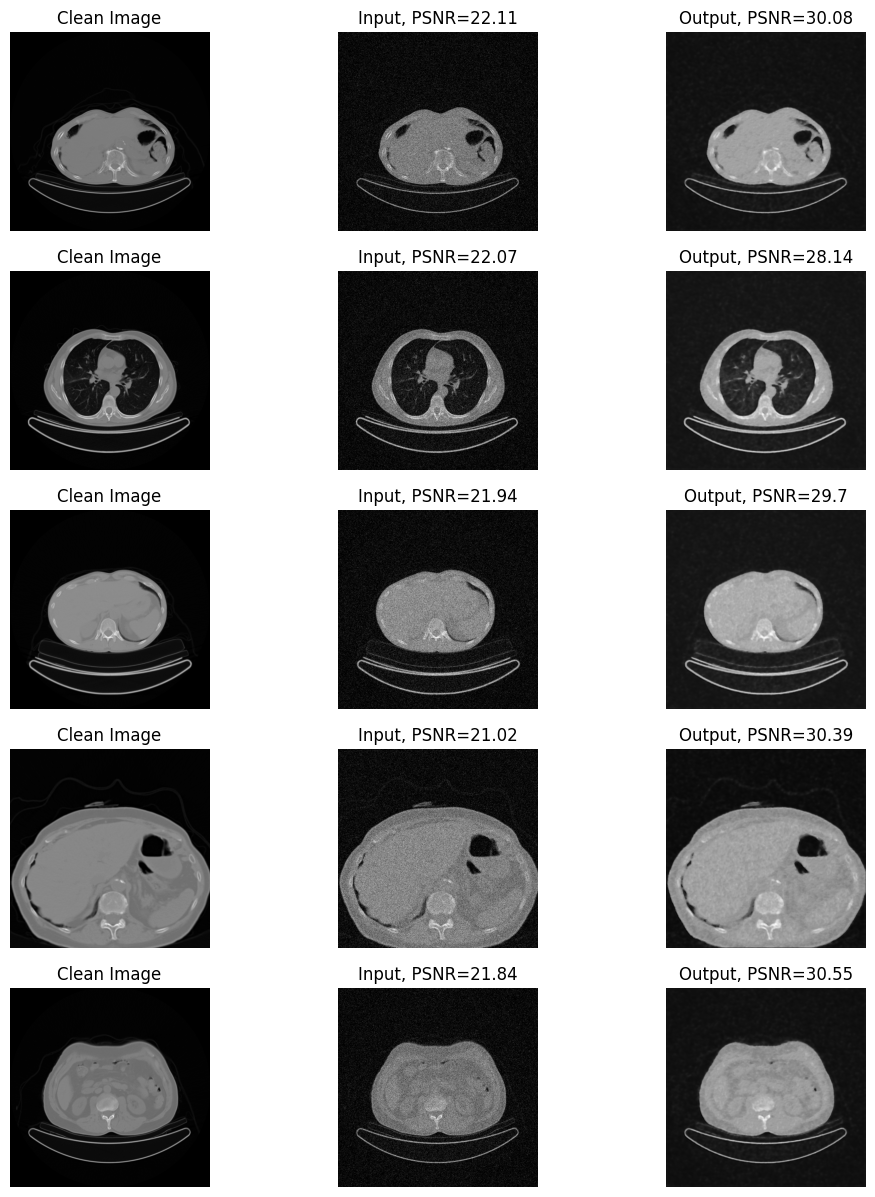

In [59]:
def calcPSNR(image, source):
    L = torch.max(image)
    R = L ** 2 / (1 / (image.shape[0] * image.shape[1]) * torch.sum((image - source) ** 2))
    return float(10 * torch.log10(R))


def reconstruct_img_from_patches(result, ds, index, image_size, patch_size, stride):
    image_width, image_height = image_size
    n_width_patches = (image_width - patch_size[0]) // stride + 1
    n_height_patches = (image_height - patch_size[1]) // stride + 1
    reconst_input = torch.zeros(image_size, dtype=torch.float32)
    reconst_output = torch.zeros(image_size, dtype=torch.float32)
    reconst_clean_image = torch.zeros(image_size, dtype=torch.float32)
    for i in range(n_width_patches):
        for j in range(n_height_patches):
            item_index = i * n_width_patches + j
            start_index_i = i * stride
            end_index_i = start_index_i + patch_size[0]
            start_index_j = j * stride
            end_index_j = start_index_j + patch_size[1]
            noisy_image, _ = ds.__getitem__(index + item_index)
            reconst_input[start_index_i:end_index_i, start_index_j:end_index_j] = noisy_image
            reconst_output[start_index_i:end_index_i, start_index_j:end_index_j] = result[index + item_index][0].to('cpu')
            clean_image = ds.get_row_item(index + item_index)
            reconst_clean_image[start_index_i:end_index_i, start_index_j:end_index_j] = torch.tensor(clean_image, dtype=torch.float32)
    return reconst_clean_image, reconst_input, reconst_output


plt.figure(figsize=(12, 15))
n, k = 5, 3
for i in range(n):
    index = i * test_ds.n_patches
    reconst_clean_image, reconst_input, reconst_output = reconstruct_img_from_patches(result, test_ds, index, (512, 512), patch_size, stride)
    denoised_img = reconst_input - reconst_output
    denoised_img[denoised_img < 0] = 0
    denoised_img[denoised_img > 1] = 1

    plt.subplot(n, k, k*i+1)
    plt.imshow(reconst_clean_image, cmap='gray')
    plt.title('Clean Image')
    plt.axis('off')

    noisy_psnr = round(calcPSNR(reconst_input, reconst_clean_image), 2)
    denoised_psnr = round(calcPSNR(reconst_output, reconst_clean_image), 2)

    plt.subplot(n, k, k*i+2)
    plt.imshow(reconst_input, cmap='gray')
    plt.title('Input, PSNR=' + str(noisy_psnr))
    plt.axis('off')

    plt.subplot(n, k, k*i+3)
    plt.imshow(reconst_output, cmap='gray')
    plt.title('Output, PSNR=' + str(denoised_psnr))
    plt.axis('off')

plt.show()